In [ ]:
import os
import numpy as np
import pandas as pd
import gdown
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
# pip install torchsummary

# Data

In [ ]:
if not os.path.exists('./LIDC_crops'):
    url = 'https://drive.google.com/uc?id=14BECMfFtECu6dbaqFXw6cmASVYc2JREM'
    gdown.download(url, './LIDC_DLCV_version.zip', quiet=False)
    !unzip ./LIDC_DLCV_version.zip > /dev/null
    !rm ./LIDC_DLCV_version.zip

Downloading...
From: https://drive.google.com/uc?id=14BECMfFtECu6dbaqFXw6cmASVYc2JREM
To: /content/LIDC_DLCV_version.zip
112MB [00:01, 56.5MB/s]


In [ ]:
!cd LIDC_crops/LIDC_DLCV_version/test/images && ls | head

LIDC-IDRI-0007_z-102.0_c0.png
LIDC-IDRI-0007_z-104.5_c0.png
LIDC-IDRI-0007_z-107.0_c0.png
LIDC-IDRI-0007_z-37.0_c0.png
LIDC-IDRI-0007_z-39.5_c0.png
LIDC-IDRI-0007_z-42.0_c0.png
LIDC-IDRI-0007_z-44.5_c0.png
LIDC-IDRI-0007_z-47.0_c0.png
LIDC-IDRI-0007_z-49.5_c0.png
LIDC-IDRI-0007_z-52.0_c0.png


In [ ]:
!cd LIDC_crops/LIDC_DLCV_version/test/lesions && ls | head

LIDC-IDRI-0007_z-102.0_c0_l0.png
LIDC-IDRI-0007_z-102.0_c0_l1.png
LIDC-IDRI-0007_z-102.0_c0_l2.png
LIDC-IDRI-0007_z-102.0_c0_l3.png
LIDC-IDRI-0007_z-104.5_c0_l0.png
LIDC-IDRI-0007_z-104.5_c0_l1.png
LIDC-IDRI-0007_z-104.5_c0_l2.png
LIDC-IDRI-0007_z-104.5_c0_l3.png
LIDC-IDRI-0007_z-107.0_c0_l0.png
LIDC-IDRI-0007_z-107.0_c0_l1.png


In [ ]:
sorted(glob.glob(os.path.join("LIDC_crops/LIDC_DLCV_version", "test", "images", "*.png")))[:10]

['LIDC_crops/LIDC_DLCV_version/test/images/LIDC-IDRI-0007_z-102.0_c0.png',
 'LIDC_crops/LIDC_DLCV_version/test/images/LIDC-IDRI-0007_z-104.5_c0.png',
 'LIDC_crops/LIDC_DLCV_version/test/images/LIDC-IDRI-0007_z-107.0_c0.png',
 'LIDC_crops/LIDC_DLCV_version/test/images/LIDC-IDRI-0007_z-37.0_c0.png',
 'LIDC_crops/LIDC_DLCV_version/test/images/LIDC-IDRI-0007_z-39.5_c0.png',
 'LIDC_crops/LIDC_DLCV_version/test/images/LIDC-IDRI-0007_z-42.0_c0.png',
 'LIDC_crops/LIDC_DLCV_version/test/images/LIDC-IDRI-0007_z-44.5_c0.png',
 'LIDC_crops/LIDC_DLCV_version/test/images/LIDC-IDRI-0007_z-47.0_c0.png',
 'LIDC_crops/LIDC_DLCV_version/test/images/LIDC-IDRI-0007_z-49.5_c0.png',
 'LIDC_crops/LIDC_DLCV_version/test/images/LIDC-IDRI-0007_z-52.0_c0.png']

In [ ]:
import torchvision.transforms.functional as TF

class LIDC_DLCV(torch.utils.data.Dataset):

    def __init__(self, state, mask_idx, path="LIDC_crops/LIDC_DLCV_version", output_size=128):
        assert state in ["test", "val", "train"]
        
        self.path = path
        self.state = state
        self.images = sorted(glob.glob(os.path.join(path, state, "images", "*.png")))
        self.mask_convert = {0: "_l0", 1: "_l1", 2: "_l2", 3: "_l3"}
        self.mask_idx = mask_idx
        self._output_size = output_size
        
    def __len__(self):
        return len(self.images)

    def _transform(self, image, mask):
        "Do transformation and return"

        # Resize
        resize = transforms.Resize(size=(self._output_size, self._output_size))
        image = resize(image)
        mask = resize(mask)

        # Augmentation
        aug_rotate = transforms.RandomRotation(degrees=(0, 90))
        aug_flip = transforms.RandomHorizontalFlip()
        image = aug_rotate(image)
        image = aug_flip(image)
        mask = aug_rotate(mask)
        mask = aug_flip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask[mask > 0] = 1.0
        return image, mask

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        mask_path = os.path.basename(self.images[idx])[:-4] + self.mask_convert[self.mask_idx] + ".png"
        mask = Image.open(os.path.join(self.path, self.state, "lesions", mask_path))
        img, mask = self._transform(img, mask)
        return img, mask

In [ ]:
batch_size = 64
# Train and test data
trainset = LIDC_DLCV(state="train", mask_idx=0)
print("Number of training samples are", len(trainset))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = LIDC_DLCV(state="test", mask_idx=0)
print("Number of test samples are", len(trainset))
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
valset = LIDC_DLCV(state="val", mask_idx=0)
print("Number of validation samples are", len(valset))
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=3)

Number of training samples are 8843
Number of test samples are 8843
Number of validation samples are 1993


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Functions

## General

In [ ]:
def train(model, opt, epochs, data_tr, data_val, loss_fn=None):
    X_val, Y_val = next(iter(data_val))
    loss_train = []
    loss_val = []

    for epoch in tqdm(range(epochs), unit='epoch'):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss_tr = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            if loss_fn == None:
                weights = torch.tensor([0.9941]).to(device)
                loss_fun = torch.nn.BCEWithLogitsLoss(pos_weight=weights)
                loss = loss_fun(Y_pred, Y_batch)
            else:
                loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
            
            # calculate metrics
            avg_loss_tr += loss / len(data_tr)
        toc = time()
        print(' - loss: %f' % avg_loss_tr)

        # validation set
        avg_loss_val = 0
        model.eval()  # testing mode
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            with torch.no_grad():
                Y_pred = model(X_batch)           
            if loss_fn == None:
                weights = torch.tensor([0.9941]).to(device)
                loss_fun = torch.nn.BCEWithLogitsLoss(pos_weight=weights)
                loss = loss_fun(Y_pred, Y_batch)
            else:
                loss = loss_fn(Y_batch, Y_pred)
            
            # Calculate metrics
            avg_loss_val += loss / len(data_val)
            

        # Show intermediate results
        Y_hat = F.sigmoid(model(X_val.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(X_val[k].numpy().squeeze(0), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_val[k].numpy().squeeze(0), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss_tr))
        plt.show()

        loss_train.append(avg_loss_tr.item())
        loss_val.append(avg_loss_val.item())

    return loss_train, loss_val

In [ ]:
def compute_metrics(target, prediction, threshold):

    def compute_IoU(target, prediction):
        intersection = torch.sum(torch.logical_and(target, prediction))
        union = torch.sum(torch.logical_or(target, prediction))
        return (intersection.item()/union.item())

    def compute_confusion(target, prediction):
        TP = torch.sum(torch.logical_and(prediction == 1, target == 1))
        TN = torch.sum(torch.logical_and(prediction == 0, target == 0))
        FP = torch.sum(torch.logical_and(prediction == 1, target == 0))
        FN = torch.sum(torch.logical_and(prediction == 0, target == 1))
        return TP.item(), TN.item(), FP.item(), FN.item()

    def compute_accuracy(TP, TN, FP, FN):
        return (TP+TN)/(TP+TN+FP+FN)
    
    def compute_ss(TP, TN, FP, FN):
        try:
            sensitivity = TP/(TP+FN)
        except ZeroDivisionError:
            sensitivity = 0
        try:
            specificity = TN/(TN+FP)
        except ZeroDivisionError:
            specificity = 0
        return sensitivity, specificity
    
    def compute_dice(target, prediction):
        num = 2 * torch.sum(torch.logical_and(target, prediction))
        den = target.sum() + prediction.sum()
        return num.item()/den.item()
    
    prediction[prediction >= threshold] = 1.0
    prediction[prediction < threshold] = 0.0
    iou = compute_IoU(target, prediction)
    TP, TN, FP, FN = compute_confusion(target, prediction)
    accuracy = compute_accuracy(TP, TN, FP, FN)
    sensitivity, specificity = compute_ss(TP, TN, FP, FN)
    dice = compute_dice(target, prediction)
    
    return iou, accuracy, sensitivity, specificity, dice

In [ ]:
def predict(model, data, threshold):
    batch_metrics = {'iou': [],
                    'accuracy': [],
                    'sensitivity': [],
                    'specificity': [],
                    'dice': []}
    for X_batch, Y_batch in data:
        model.eval()
        X_batch = X_batch.to(device)
        with torch.no_grad():
            Y_pred = model(X_batch)
        Y_hat = F.sigmoid(Y_pred).detach().cpu()
        iou, accuracy, sensitivity, specificity, dice = compute_metrics(Y_batch, Y_hat, threshold)
        batch_metrics['iou'].append(iou)
        batch_metrics['accuracy'].append(accuracy)
        batch_metrics['sensitivity'].append(sensitivity)
        batch_metrics['specificity'].append(specificity)
        batch_metrics['dice'].append(dice)

    iou_avg = np.mean(batch_metrics['iou'])
    accuracy_avg = np.mean(batch_metrics['accuracy'])
    sensitivity_avg = np.mean(batch_metrics['sensitivity'])
    specificity_avg = np.mean(batch_metrics['specificity'])
    dice_avg = np.mean(batch_metrics['dice'])

    batch_metrics_avg = [iou_avg, accuracy_avg, sensitivity_avg, specificity_avg, dice_avg]
    
    return batch_metrics, batch_metrics_avg

## Losses

In [ ]:
def bce_loss(y_real, y_pred):
  return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

In [ ]:
def focal_loss(y_real, y_pred, gamma=2):
    y_pred = torch.clamp(F.sigmoid(y_pred), 1e-8, 1-1e-8)
    gamma = 2
    return -torch.mean(((1-y_pred)**gamma)*y_real*torch.log(y_pred) + (1-y_real)*torch.log(1-y_pred))

# SegNet

In [ ]:
# Proportion of black (to calculate weight) on training set
black = 0
total_pix = 0
for X_val, Y_val in train_loader:
    total_pix += 128*128*Y_val.size()[0]
    black += 128*128*Y_val.size()[0] - torch.sum(Y_val)
print(black/total_pix)

tensor(0.9941)


In [ ]:
# Proportion of black (to calculate weight) on test set
black = 0
total_pix = 0
for X_val, Y_val in test_loader:
    total_pix += 128*128*Y_val.size()[0]
    black += 128*128*Y_val.size()[0] - torch.sum(Y_val)
print(black/total_pix)

tensor(0.9935)


In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d(2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(size = 16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(size = 32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(size=64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.upsample3 = nn.Upsample(size=128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [ ]:
model_segnet = SegNet().to(device)
loss_tr_segnet, loss_val_segnet = train(model_segnet, optim.Adam(model_segnet.parameters(), lr=1e-4), 50, train_loader, val_loader, focal_loss)

In [ ]:
train_metrics_series_snet, train_metrics_snet = predict(model_segnet, train_loader, 0.9)
test_metrics_series_snet, test_metrics_snet = predict(model_segnet, test_loader, 0.9)
val_metrics_series_snet, val_metrics_snet = predict(model_segnet, val_loader, 0.9)

In [ ]:
model_segnet2 = SegNet().to(device)
loss_tr_segnet2, loss_val_segnet2 = train(model_segnet2, optim.Adam(model_segnet2.parameters(), lr=1e-4), 50, train_loader, val_loader)

In [ ]:
train_metrics_series_snet2, train_metrics_snet2 = predict(model_segnet2, train_loader, 0.9)
test_metrics_series_snet2, test_metrics_snet2 = predict(model_segnet2, test_loader, 0.9)
val_metrics_series_snet2, val_metrics_snet2 = predict(model_segnet2, val_loader, 0.9)

In [ ]:
metrics_snet = [train_metrics_snet, train_metrics_snet2, test_metrics_snet, test_metrics_snet2,
                val_metrics_snet, val_metrics_snet2]
df_results_snet = pd.DataFrame(data=metrics_snet,
                               index=['Training Focal',
                                      'Training weighted BCE',
                                      'Test Focal',
                                      'Test weighted BCE',
                                      'Validation Focal',
                                      'Validation weighted BCE'],
                               columns=['IoU', 'Accuracy', 'Sensitivity', 'Specificity', 'Dice'])
print(df_results_snet.to_latex())

## Testing metrics

In [ ]:
X_test_batch, Y_test_batch = next(iter(train_loader))

In [ ]:
X_test_batch.shape

torch.Size([64, 1, 128, 128])

In [ ]:
model.eval()
X_test_batch = X_test_batch.to(device)
with torch.no_grad():
    Y_test_pred = model(X_test_batch)
    Y_test_hat = F.sigmoid(Y_test_pred).detach().cpu()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
Y_test_hat[Y_test_hat >= 0.9] = 1.0
Y_test_hat[Y_test_hat < 0.9] = 0.0

In [ ]:
Y_test_hat[0][0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
intersection = torch.logical_and(Y_test_batch, Y_test_hat)
union = torch.logical_or(Y_test_batch, Y_test_hat)
print(intersection.sum(), union.sum(), intersection.sum().item()/union.sum().item())

tensor(4612) tensor(7237) 0.6372806411496477


In [ ]:
TP = torch.sum(torch.logical_and(Y_test_hat == 1, Y_test_batch == 1))
TN = torch.sum(torch.logical_and(Y_test_hat == 0, Y_test_batch == 0))
FP = torch.sum(torch.logical_and(Y_test_hat == 1, Y_test_batch == 0))
FN = torch.sum(torch.logical_and(Y_test_hat == 0, Y_test_batch == 1))
print(TP, TN, FP, FN)

tensor(4612) tensor(1041339) tensor(35) tensor(2590)


In [ ]:
(TP+TN)/(TP+TN+FP+FN) # weird, use .item() for tensor rank 0 => 1 element

tensor(0)

In [ ]:
(TP.item()+TN.item())/(TP.item()+TN.item()+FP.item()+FN.item())

0.9974966049194336

# U-Net

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)
    
    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        skip0 = torch.cat([self.upsample0(b), F.relu(self.enc_conv3(e2))], 1)
        d0 = F.relu(self.dec_conv0(skip0))
        skip1 = torch.cat([self.upsample1(d0), F.relu(self.enc_conv2(e1))], 1)
        d1 = F.relu(self.dec_conv1(skip1))
        skip2 = torch.cat([self.upsample2(d1), F.relu(self.enc_conv1(e0))], 1)
        d2 = F.relu(self.dec_conv2(skip2))
        skip3 = torch.cat([self.upsample3(d2), F.relu(self.enc_conv0(x))], 1)
        d3 = self.dec_conv3(skip3)  # no activation
        return d3

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)
    
    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        skip0 = torch.cat([self.upsample0(b), F.relu(self.enc_conv3(e2))], 1)
        d0 = F.relu(self.dec_conv0(skip0))
        skip1 = torch.cat([self.upsample1(d0), F.relu(self.enc_conv2(e1))], 1)
        d1 = F.relu(self.dec_conv1(skip1))
        skip2 = torch.cat([self.upsample2(d1), F.relu(self.enc_conv1(e0))], 1)
        d2 = F.relu(self.dec_conv2(skip2))
        skip3 = torch.cat([self.upsample3(d2), F.relu(self.enc_conv0(x))], 1)
        d3 = self.dec_conv3(skip3)  # no activation
        return d3

In [ ]:
class UNet3(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(128, 1, 3, padding=1)
    
    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        skip0 = torch.cat([self.upsample0(b), F.relu(self.enc_conv3(e2))], 1)
        d0 = F.relu(self.dec_conv0(skip0))
        skip1 = torch.cat([self.upsample1(d0), F.relu(self.enc_conv2(e1))], 1)
        d1 = F.relu(self.dec_conv1(skip1))
        skip2 = torch.cat([self.upsample2(d1), F.relu(self.enc_conv1(e0))], 1)
        d2 = F.relu(self.dec_conv2(skip2))
        skip3 = torch.cat([self.upsample3(d2), F.relu(self.enc_conv0(x))], 1)
        d3 = self.dec_conv3(skip3)  # no activation
        return d3

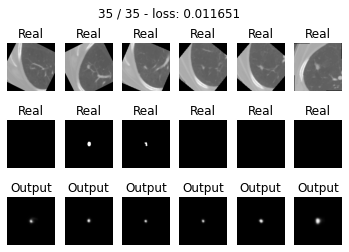

In [ ]:
model_unet = UNet().to(device)
loss_tr_unet, loss_val_unet = train(model_unet, optim.Adam(model_unet.parameters(), lr=1e-4), 35, train_loader, val_loader)

Text(0, 0.5, 'Loss')

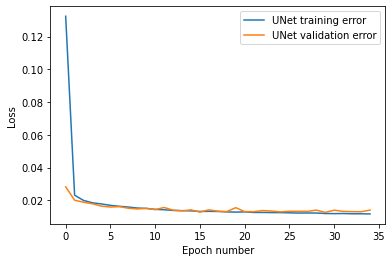

In [ ]:
plt.plot(range(len(loss_tr_unet)), loss_tr_unet)
plt.plot(range(len(loss_val_unet)), loss_val_unet)
plt.legend(('UNet training error','UNet validation error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

In [ ]:
train_metrics_series_unet, train_metrics_unet = predict(model_unet, train_loader, 0.5)
test_metrics_series_unet, test_metrics_unet = predict(model_unet, test_loader, 0.5)
val_metrics_series_unet, val_metrics_unet = predict(model_unet, val_loader, 0.5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
metrics_unet = [train_metrics_unet, test_metrics_unet, val_metrics_unet]
df_results_unet = pd.DataFrame(data=metrics_unet,
                               index=['Training Upsample',
                                      'Test Upsample',
                                      'Validation Upsample'],
                               columns=['IoU', 'Accuracy', 'Sensitivity', 'Specificity', 'Dice'])
df_results_unet

,IoU,Accuracy,Sensitivity,Specificity,Dice
Training Upsample,0.333604,0.995780,0.365369,0.999450,0.496788
Test Upsample,0.286529,0.995425,0.312645,0.999597,0.419900
Validation Upsample,0.233624,0.995031,0.259379,0.999359,0.346822


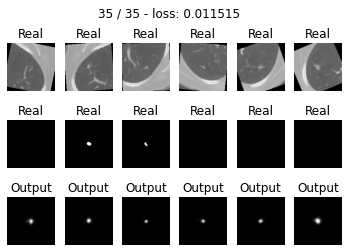

In [ ]:
model_unet2 = UNet2().to(device)
loss_tr_unet2, loss_val_unet2 = train(model_unet2, optim.Adam(model_unet2.parameters(), lr=1e-4), 35, train_loader, val_loader)

In [ ]:
train_metrics_series_unet2, train_metrics_unet2 = predict(model_unet2, train_loader, 0.5)
test_metrics_series_unet2, test_metrics_unet2 = predict(model_unet2, test_loader, 0.5)
val_metrics_series_unet2, val_metrics_unet2 = predict(model_unet2, val_loader, 0.5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0, 0.5, 'Loss')

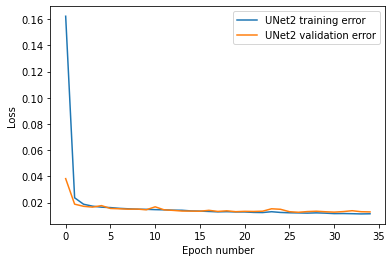

In [ ]:
plt.plot(range(len(loss_tr_unet2)), loss_tr_unet2)
plt.plot(range(len(loss_val_unet2)), loss_val_unet2)
plt.legend(('UNet2 training error','UNet2 validation error'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')

In [ ]:
metrics_unet = [train_metrics_unet, train_metrics_unet2, test_metrics_unet, test_metrics_unet2,
                val_metrics_unet, val_metrics_unet2]
df_results_unet = pd.DataFrame(data=metrics_unet,
                               index=['Training Upsample',
                                      'Training Transposed Conv',
                                      'Test Upsample',
                                      'Test Transposed Conv',
                                      'Validation Upsample',
                                      'Validation Transposed Conv'],
                               columns=['IoU', 'Accuracy', 'Sensitivity', 'Specificity', 'Dice'])
df_results_unet

,IoU,Accuracy,Sensitivity,Specificity,Dice
Training Upsample,0.333604,0.995780,0.365369,0.999450,0.496788
Training Transposed Conv,0.364443,0.995876,0.408121,0.999302,0.529869
Test Upsample,0.286529,0.995425,0.312645,0.999597,0.419900
Test Transposed Conv,0.289233,0.995439,0.327517,0.999392,0.421268
Validation Upsample,0.233624,0.995031,0.259379,0.999359,0.346822
Validation Transposed Conv,0.247271,0.995227,0.285936,0.999170,0.362314


In [ ]:
def plot_predict(model, data, threshold, epoch):
    model.eval()
    for i, (X, Y) in enumerate(data):
        if i == epoch:
            X = X.to(device)
            with torch.no_grad():
                Y_pred = model(X)
            Y_hat = F.sigmoid(Y_pred).detach().cpu()
            Y_hat[Y_hat >= threshold] = 1.0
            Y_hat[Y_hat < threshold] = 0.0
            for idx in range(Y.shape[0]):
                plt.imshow(Y[idx].squeeze(), alpha=0.5, cmap='Reds')
                plt.imshow(Y_hat[idx].squeeze(), alpha=0.5, cmap='Blues')
                plt.imshow(X[idx].cpu().numpy().squeeze(0), alpha=0.3, cmap='gray')
                plt.show()

In [ ]:
plot_predict(model_unet, val_loader, 0.5, 0)

Output hidden; open in https://colab.research.google.com to view.

# Ensemble

In [ ]:
testset0 = LIDC_DLCV(state="test", mask_idx=0)
test_loader0 = DataLoader(testset0, batch_size=batch_size, shuffle=False, num_workers=3)
testset1 = LIDC_DLCV(state="test", mask_idx=1)
test_loader1 = DataLoader(testset1, batch_size=batch_size, shuffle=False, num_workers=3)
testset2 = LIDC_DLCV(state="test", mask_idx=2)
test_loader2 = DataLoader(testset2, batch_size=batch_size, shuffle=False, num_workers=3)
testset3 = LIDC_DLCV(state="test", mask_idx=3)
test_loader3 = DataLoader(testset3, batch_size=batch_size, shuffle=False, num_workers=3)

In [ ]:
testset0.images == testset1.images

True

In [ ]:
data_loaders = [test_loader0, test_loader1]
models = [model_unet, model_unet2]
# models = [model_segnet0, model_segnet1, model_segnet2, model_segnet3]

In [ ]:
def calculate_ensemble(models, data_loaders, epoch, idx):

    def predict_ensemble(models, data_loaders, epoch, idx):
        Y_hats = []
        Ys = []
        Xs = []
        for i, data in enumerate(data_loaders):
            models[i].eval()
            for j, (X_batch, Y_batch) in enumerate(data):
                if j == epoch:
                    X_batch = X_batch.to(device)
                    with torch.no_grad():
                        Y_pred = models[i](X_batch)
                    Y_hat = F.sigmoid(Y_pred).detach().cpu()
                    Y_hats.append(Y_hat[idx])
                    Ys.append(Y_batch[idx])
                    Xs.append(X_batch[idx])
        
        return Y_hats, Ys, Xs

    def average_ensemble(Y_hats, Ys):
        Y_hats_mean = torch.mean(torch.cat(Y_hats, 0), 0)
        Y_hats_std = torch.std(torch.cat(Y_hats, 0), 0)
        Ys_mean = torch.mean(torch.cat(Ys, 0), 0)
        Ys_std = torch.std(torch.cat(Ys, 0), 0)

        return Y_hats_mean, Y_hats_std, Ys_mean, Ys_std

    def plot_ensemble(Y_hats, Ys, Xs):
        plt.imshow(Ys, alpha=0.5, cmap='Reds')
        plt.imshow(Y_hats, alpha=0.5, cmap='Blues')
        plt.imshow(Xs[0].squeeze().cpu(), alpha=0.3, cmap='gray')
        plt.show()
    
    Y_hats, Ys, Xs = predict_ensemble(models, data_loaders, epoch, idx)
    Y_hats_mean, Y_hats_std, Ys_mean, Ys_std = average_ensemble(Y_hats, Ys)
    plot_ensemble(Y_hats_mean, Ys_mean, Xs)
    plot_ensemble(Y_hats_std, Ys_std, Xs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


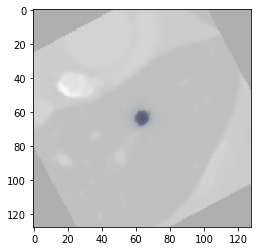

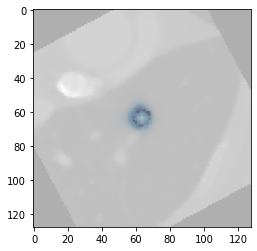

In [ ]:
calculate_ensemble(models, data_loaders, epoch=1, idx=5)

In [ ]:
Y_preds_unet, Y_unet, X_unet = predict_ensemble(models, data_loaders, epoch=0, idx=0)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
test = torch.cat(Y_preds_unet, 0)

In [ ]:
def plot_ensemble(Y_hats, Ys, Xs):
    for idx in range(len(Ys)):
        plt.imshow(Ys[idx], alpha=0.5, cmap='Reds')
        plt.imshow(Y_hats[idx], alpha=0.5, cmap='Blues')
        plt.imshow(Xs[idx].cpu(), alpha=0.3, cmap='gray')
        plt.show()

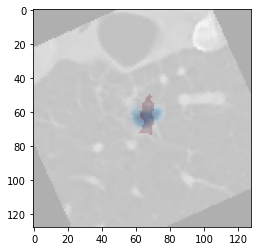

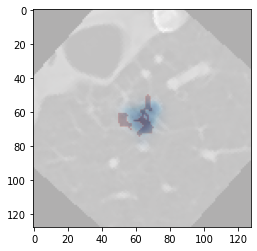

In [ ]:
plot_ensemble(Y_preds_unet, Y_unet, X_unet)